# Approximating the Diffusion Equation

## Forward Euler

In [2]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from euler import solve_diffusion_equation_FE, analytical_solution
from ffnn_pde_solver import PDESolver
from trial_functions import u_trial, u_analytical

2022-12-18 03:21:33.996753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 03:21:35.417437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-18 03:21:35.417654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-18 03:21:35.417663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

First, we will simulate the diffusion equation in 1D using forward Euler. We will use the following parameters:


In [2]:
dx = 0.01 
dt = 0.00001 # Chosen to satisfy the stability condition
T = 1 # Total duration of the simulation
L = 1 # Length of the rod

First, we will plot the analytical solution:

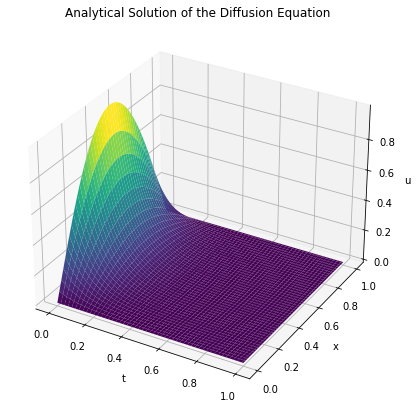

In [3]:
x = np.linspace(0, L, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(T, X, analytical_solution(X, T), cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('Analytical Solution of the Diffusion Equation')
plt.show()

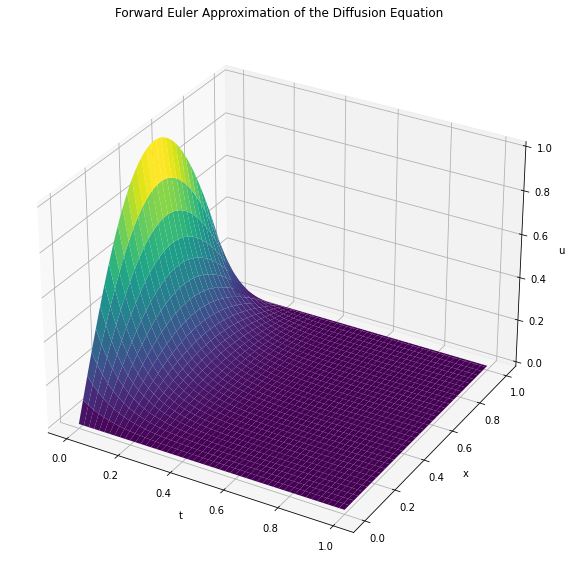

In [4]:
u = solve_diffusion_equation_FE(0.00001, 0.01, 1, plot=True)

Qualitatively similar to the FE approximation. Quantitatively, we can examine the absolute error:

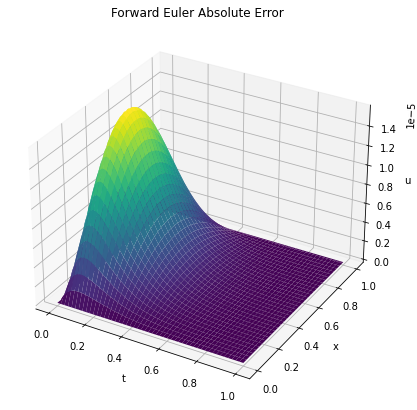

Maximum absolute error:  1.578255675016571e-05
MSE:  2.3080079455806984e-11


In [5]:
x = np.linspace(0, L, 101)
t = np.linspace(0, 1, 100000)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
absolute_error = np.absolute(
    analytical_solution(X, T) 
    - solve_diffusion_equation_FE(0.00001, 0.01, 1, plot=False)
    )
ax.plot_surface(T, X, absolute_error, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('Forward Euler Absolute Error')
plt.show()
print("Maximum absolute error: ", np.max(absolute_error))
print("MSE: ", np.mean(absolute_error**2))

We see quite low errors, however this is with a relatively small time step.

## Diffusion equation for $\Delta x$ = $\Delta t = 0.1$

In [6]:
def grid_search(xt, lambdas, etas, n_averages, hidden_layers, epochs):
    print(".", end="")
    min_loss = 1e10
    best_eta = -1
    best_lmbda = -1
    for eta in etas:
        for lmbda in lambdas:
            total_loss = 0
            for i in range(n_averages):
                model = PDESolver(
                hidden_layers=hidden_layers,
                learning_rate=eta,
                regularization=lmbda,
                problem="diffusion",
                activation_function="tanh"
                )
                model.fit(xt, epochs=epochs, verbose=0)
                total_loss += model.get_cost(xt)
            average_loss = total_loss / n_averages
            if average_loss < min_loss:
                min_loss = average_loss
                best_eta = eta
                best_lmbda = lmbda
            print(" .", end="")
    print(" Done!")
    return best_eta, best_lmbda, min_loss

Next, we will examine the performance of the PINN based approach.

In [6]:
dt = 0.1
dx = 0.1
T = 1
L = 1

In [7]:
t = np.linspace(0, T, int(T/dt) + 1)
x = np.linspace(0, L, int(L/dx) + 1)
xx, tt = np.meshgrid(x, t)
grid_shape = xx.shape
xx = xx.flatten()
tt = tt.flatten()
xt = np.vstack((xx, tt)).T

We run a grid search to find the optimal hyperparameters:

In [46]:
hidden_layers = [128, 128, 128]
lambdas = [0, 1e-7, 1e-6, 1e-5]
etas = [1e-5, 1e-4, 1e-3, 1e-2]
n_averages = 20
epochs = 1000

best_eta, best_lmbda, min_loss = grid_search(xt, lambdas, etas, n_averages, hidden_layers, epochs)
print(best_eta, best_lmbda, min_loss)


. . . . . . . . . . . . . . . . . Done!
0.001 1e-07 0.004037055364460684


We now create a model using the optimal hyperparameters.


In [50]:
hidden_layers = [128, 128, 128]
epochs = 1000
model = PDESolver(
    hidden_layers=hidden_layers,
    learning_rate=best_eta,
    regularization=best_lmbda,
    problem="diffusion",
    activation_function="tanh"
    )
from time import time
start = time()
model.fit(xt, epochs=epochs)
end = time()
print("Training time: ", end - start)

Epoch 1/1000
4/4 [==============================] - 1s 4ms/step - loss: 11.1540
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.7687
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.5928
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.3156
Epoch 5/1000
4/4 [==============================] - 0s 4ms/step - loss: 10.1183
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.7099
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 9.4043
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.7697
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 8.0290
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 7.2072
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 6.7512
Epoch 12/1000
4/4 [==============================] - 0s 4ms/step - loss: 5.8463
Epoch 13/1000
4/4 [=========================

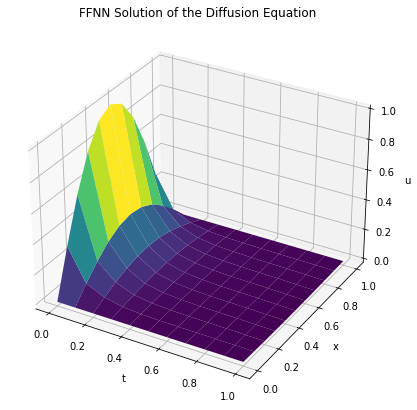

In [55]:
N = model(xt)

xx = xx.reshape(grid_shape)
tt = tt.reshape(grid_shape)
N = N.reshape(grid_shape)
u = u_trial(xx, tt, N)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('FFNN Solution of the Diffusion Equation')
ax.plot_surface(tt, xx, u, cmap='viridis')
plt.savefig("Plots/ffnn_solution_dt1e-1_dx1e-1.pdf")
plt.show()

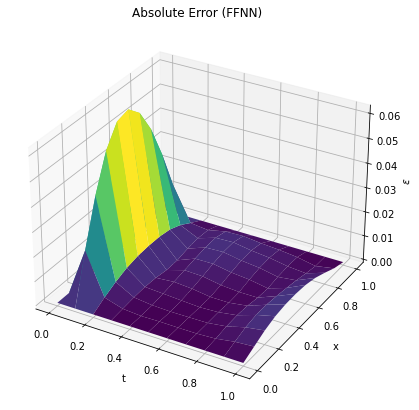

MSE: 0.00016505813105994557
Max absolute error: 0.061955542405684016


In [56]:
# Compute the absolute error
absolute_error = np.absolute(
    u_analytical(xx, tt) - u
    )

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute Error (FFNN)')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$\epsilon$')
ax.plot_surface(tt, xx, absolute_error, cmap='viridis')
plt.show()

print("MSE:", np.mean(absolute_error**2))
print("Max absolute error:", np.max(absolute_error))


Compare with FE on same discretization.

In [12]:
FE_absolute_error = np.absolute(
    analytical_solution(xx, tt) 
    - solve_diffusion_equation_FE(dt, dx, 1, plot=False)
    )
print("FE MSE:", np.mean(FE_absolute_error**2))
print("FE Max absolute error:", np.max(FE_absolute_error))

FE MSE: 0.006138909952070619
FE Max absolute error: 0.351577512950366


Plot Forward euler on this discretization.

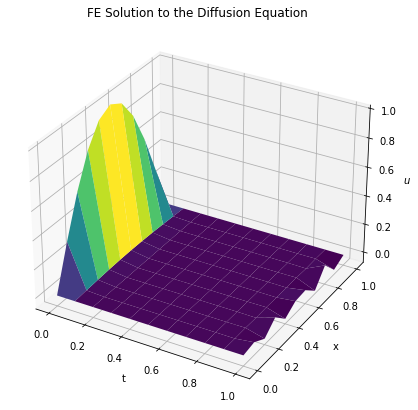

In [75]:
FE_u = solve_diffusion_equation_FE(dt, dx, 1, plot=False)

# plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('FE Solution to the Diffusion Equation')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$u$')
ax.plot_surface(tt, xx, FE_u, cmap='viridis')
plt.savefig("Plots/FE_solution_dt1e-1_dx1e-1.pdf")
plt.show()

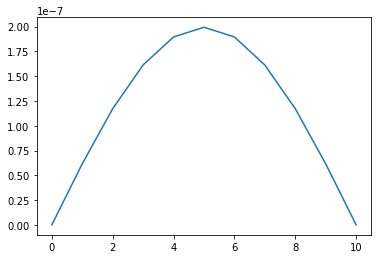

In [74]:
plt.plot(FE_u[4, :], label="FFNN")

## Diffusion equation for $\Delta x= 0.1$  and  $\Delta t = 0.001$

Next, we will examine the performance of the PINN based approach.

In [7]:
dt = 0.001
dx = 0.1
T = 1
L = 1

In [8]:
t = np.linspace(0, T, int(T/dt) + 1)
x = np.linspace(0, L, int(L/dx) + 1)
xx, tt = np.meshgrid(x, t)
grid_shape = xx.shape
xx = xx.flatten()
tt = tt.flatten()
xt = np.vstack((xx, tt)).T

We run a grid search to find the optimal hyperparameters:

In [15]:
hidden_layers = [128, 128, 128]
lambdas = [0, 1e-7, 1e-6, 1e-5]
etas = [1e-5, 1e-4, 1e-3, 1e-2]
n_averages = 5
epochs = 100

best_eta, best_lmbda, min_loss = grid_search(xt, lambdas, etas, n_averages, hidden_layers, epochs)
print(best_eta, best_lmbda, min_loss)


. . . . . . . . . . . . . . . . . Done!
0.0001 0 0.00025022740155691283


We now create a model using the optimal hyperparameters.


In [16]:
hidden_layers = [128, 128, 128]
epochs = 200
model = PDESolver(
    hidden_layers=hidden_layers,
    #learning_rate=best_eta,
    #regularization=best_lmbda,
    problem="diffusion",
    activation_function="tanh"
    )
from time import time
start = time()
model.fit(xt, epochs=epochs)
end = time()
print("Training time: ", end - start)

Epoch 1/200
345/345 [==============================] - 2s 2ms/step - loss: 3.9788
Epoch 2/200
345/345 [==============================] - 1s 2ms/step - loss: 0.6803
Epoch 3/200
345/345 [==============================] - 1s 2ms/step - loss: 0.1358
Epoch 4/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0539
Epoch 5/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0309
Epoch 6/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0267
Epoch 7/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0121
Epoch 8/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0100
Epoch 9/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0081
Epoch 10/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0087
Epoch 11/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 12/200
345/345 [==============================] - 1s 2ms/step - loss: 0.0180
Epoch 13/200


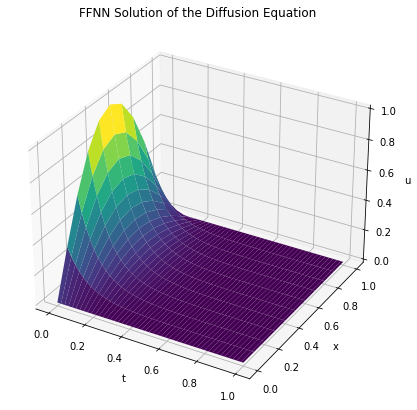

In [17]:
N = model(xt)

xx = xx.reshape(grid_shape)
tt = tt.reshape(grid_shape)
N = N.reshape(grid_shape)
u = u_trial(xx, tt, N)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u')
ax.title.set_text('FFNN Solution of the Diffusion Equation')
ax.plot_surface(tt, xx, u, cmap='viridis')
plt.savefig("Plots/ffnn_solution_dt1e-3_dx1e-1.pdf")
plt.show()

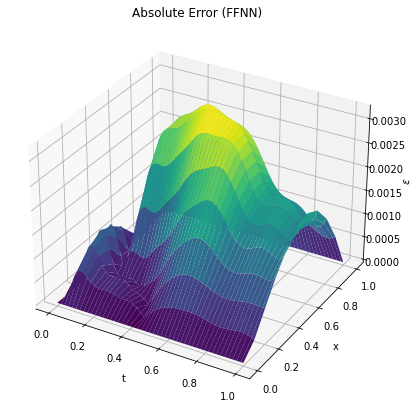

MSE: 2.135557784771848e-06
Max absolute error: 0.0032092400907516496


In [18]:
# Compute the absolute error
absolute_error = np.absolute(
    u_analytical(xx, tt) - u
    )

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('Absolute Error (FFNN)')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$\epsilon$')
ax.plot_surface(tt, xx, absolute_error, cmap='viridis')
plt.show()

print("MSE:", np.mean(absolute_error**2))
print("Max absolute error:", np.max(absolute_error))


Compare with FE on same discretization.

In [19]:
FE_absolute_error = np.absolute(
    analytical_solution(xx, tt) 
    - solve_diffusion_equation_FE(dt, dx, 1, plot=False)
    )
print("FE MSE:", np.mean(FE_absolute_error**2))
print("FE Max absolute error:", np.max(FE_absolute_error))

FE MSE: 1.2676480295022573e-07
FE Max absolute error: 0.001220247516193651


Plot Forward euler on this discretization.

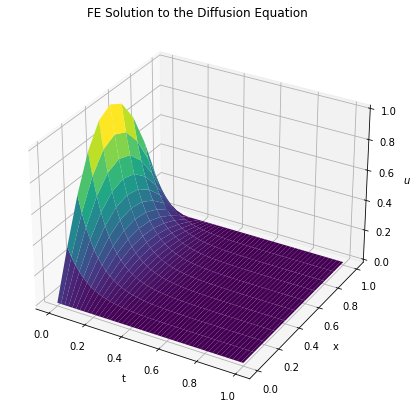

In [20]:
FE_u = solve_diffusion_equation_FE(dt, dx, 1, plot=False)

# plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('FE Solution to the Diffusion Equation')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$u$')
ax.plot_surface(tt, xx, FE_u, cmap='viridis')
plt.savefig("Plots/FE_solution_dt1e-3_dx1e-1.pdf")
plt.show()

We now fix a time t and plot the approximated solution as a function of x.

In [22]:
sns.set()

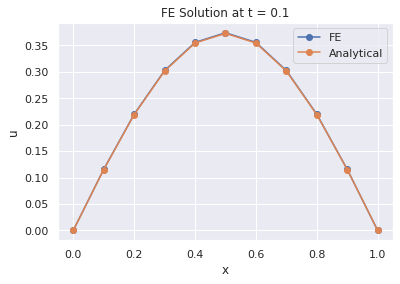

In [45]:


# plot for t = 0.1
ti = 0.1
i = int(ti/dt)
plt.plot(x, FE_u[i, :], label="FE", marker="o")
# Plot analytical solution
analytical_u = analytical_solution(xx, tt)
plt.plot(x, analytical_u[i, :], label="Analytical", marker="o")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title(f"FE Solution at t = {ti}")
plt.savefig("Plots/FE_solution_t_1e-1.pdf")
plt.show()



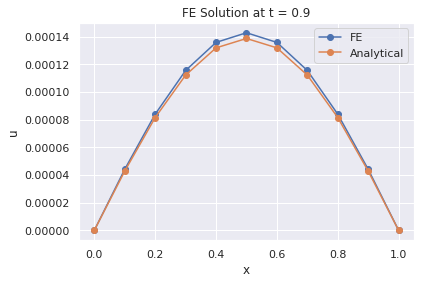

In [68]:
# plot for t = 0.9
ti = 0.9
i = int(ti/dt)
plt.plot(x, FE_u[i, :], label="FE", marker="o")
# Plot analytical solution
analytical_u = analytical_solution(xx, tt)
plt.plot(x, analytical_u[i, :], label="Analytical", marker="o")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title(f"FE Solution at t = {ti}")
# plt.savefig("Plots/FE_solution_t_9e-1.pdf")
plt.show()

In [ ]:
sns.reset_orig()

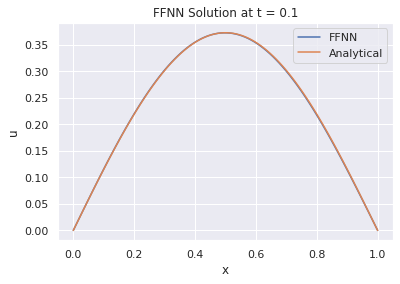

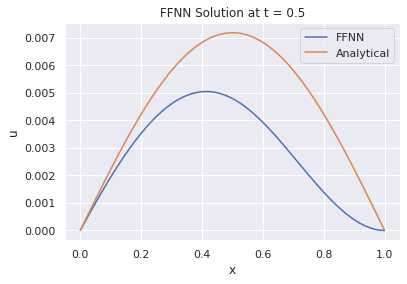

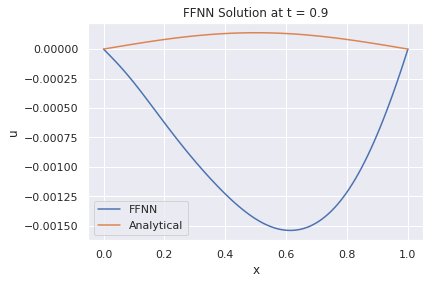

In [62]:
for t_cont, scn in zip([0.1, 0.5, 0.9], ["1e-1", "5e-1", "9e-1"]):
    x_cont = np.linspace(0, 1, 100)

    xt_test = np.vstack((x_cont, np.array([t_cont]*len(x_cont)))).T 
    N_test = model(xt_test)
    u_test = u_trial(x_cont, t_cont, N_test.flatten())
    plt.plot(x_cont, u_test)
    u_analytical = analytical_solution(x_cont, t_cont)
    plt.plot(x_cont, u_analytical)
    plt.legend(["FFNN", "Analytical"])
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(f"FFNN Solution at t = {t_cont}")
    plt.savefig("Plots/ffnn_solution_t_"+scn+".pdf")
    plt.show()



## Diffusion equation for $\Delta x= 0.01$  and  $\Delta t = 0.00001$

Next, we will examine the performance of the PINN based approach.

In [3]:
dt = 0.00001
dx = 0.01
T = 1
L = 1

In [4]:
t = np.linspace(0, T, int(T/dt) + 1)
x = np.linspace(0, L, int(L/dx) + 1)
xx, tt = np.meshgrid(x, t)
grid_shape = xx.shape
xx = xx.flatten()
tt = tt.flatten()
xt = np.vstack((xx, tt)).T

Due to size of the data set, we sample 10^5 points from the training set. For testing later.

In [5]:
idx = np.random.choice(xt.shape[0], 100_000, replace=False)
xt_sample = xt[idx, :]
print(xt.shape)
print(xt_sample.shape)

(10100000, 2)
(100000, 2)


We assume that the optimal hyperparameters are the same as for the previous case.

We now create a model using the those hyperparameters.


In [7]:
eta = 1e-4 # learning rate (from previous grid search)
lmbda = 0 # regularization parameter (from previous grid search)
hidden_layers = [128, 128, 128]
epochs = 10
model = PDESolver(
    hidden_layers=hidden_layers,
    learning_rate=eta,
    regularization=lmbda,
    problem="diffusion",
    activation_function="tanh"
    )
# from time import time
# start = time()
# model.fit(xt, epochs=epochs)
# end = time()
# print("Training time: ", end - start)

In [8]:
N = model(xt)

xx = xx.reshape(grid_shape)
tt = tt.reshape(grid_shape)
N = N.reshape(grid_shape)
u = u_trial(xx, tt, N)

# fig = plt.figure(figsize=(7,7))
# ax = plt.axes(projection='3d')
# ax.set_xlabel('t')
# ax.set_ylabel('x')
# ax.set_zlabel('u')
# ax.title.set_text('FFNN Solution of the Diffusion Equation')
# ax.plot_surface(tt, xx, u, cmap='viridis')
# plt.savefig("Plots/ffnn_solution_dt1e-3_dx1e-1.pdf")
# plt.show()

2022-12-18 03:23:08.937047: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5171200000 exceeds 10% of free system memory.


: 

: 

In [1]:
# Compute the absolute error
absolute_error = np.absolute(
    u_analytical(xx, tt) - u
    )

# fig = plt.figure(figsize=(7,7))
# ax = plt.axes(projection='3d')
# ax.set_title('Absolute Error (FFNN)')
# ax.set_xlabel('t')
# ax.set_ylabel('x')
# ax.set_zlabel('$\epsilon$')
# ax.plot_surface(tt, xx, absolute_error, cmap='viridis')
# plt.show()

print("MSE:", np.mean(absolute_error**2))
print("Max absolute error:", np.max(absolute_error))


NameError: name 'np' is not defined

Compare with FE on same discretization.

In [ ]:
FE_absolute_error = np.absolute(
    analytical_solution(xx, tt) 
    - solve_diffusion_equation_FE(dt, dx, 1, plot=False)
    )
print("FE MSE:", np.mean(FE_absolute_error**2))
print("FE Max absolute error:", np.max(FE_absolute_error))

FE MSE: 1.2676480295022573e-07
FE Max absolute error: 0.001220247516193651


Plot Forward euler on this discretization.

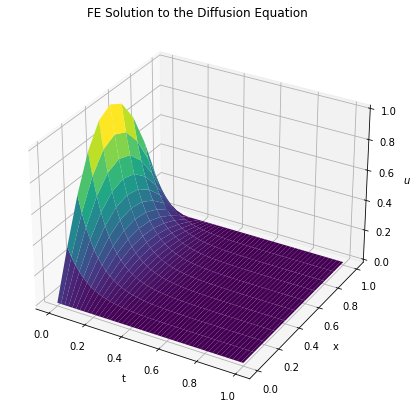

In [ ]:
FE_u = solve_diffusion_equation_FE(dt, dx, 1, plot=False)

# plot
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.set_title('FE Solution to the Diffusion Equation')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('$u$')
ax.plot_surface(tt, xx, FE_u, cmap='viridis')
plt.savefig("Plots/FE_solution_dt1e-3_dx1e-1.pdf")
plt.show()

In [13]:
nn = NeuralNetwork([2, 20, 20, 20, 1], cost_function="diffusion")
x = np.linspace(0, L, int(L/dx) + 1)
t = np.linspace(0, T, int(T/dt) + 1)
xx, tt = np.meshgrid(x, t)
# save shape of X and T
xt_shape = xx.shape

xx = xx.flatten()
tt = tt.flatten()
X = np.array([xx, tt]).T
y = np.zeros(X.shape[0])
wb = nn.wb()

start = time()
print("Initial weights and biases: ", wb.shape)
print("Initial cost: ", nn.cost(wb, X, y))
print("Initial gradient: ", nn.gradient(wb, X, y))
print("Time taken: ", time() - start)


# Run gradient descent
from gradient_descent import GradientDescent
import matplotlib.pyplot as plt
gd = GradientDescent(store_extra=True)
wb = gd.train(X, wb, X[:, 0], nn, 0.1, 100)
plt.plot(gd.costs)
plt.show()

# Compute solution at all points using diffusion_trial
sol = np.zeros((X.shape[0]))
for i in range(X.shape[0]):
    sol[i] = nn.diffusion_trial(X[i], wb)

# Reshape solution to original shape
sol = sol.reshape(xt_shape)

NameError: name 'NeuralNetwork' is not defined

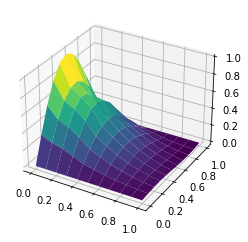

In [ ]:
# Create 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(tt.reshape(xt_shape), xx.reshape(xt_shape), sol, cmap='viridis')
plt.show()

Next, we want to compare this solution to the analytical solution. We can do this by computing the absolute error at each point in the domain.

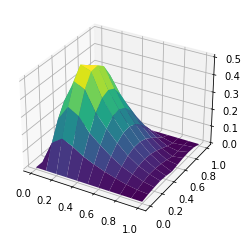

In [ ]:
#absolute error:
absolute_error = np.absolute(
    analytical_solution(xx.reshape(xt_shape), tt.reshape(xt_shape))
    - sol
    )

# Create 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(tt.reshape(xt_shape), xx.reshape(xt_shape), absolute_error, cmap='viridis')
plt.show()